In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
data = pd.read_csv("Insurance_Marketing-Customer-Value-Analysis (1).csv")

In [3]:
data['to_date'] = pd.to_datetime(data['Effective To Date'],format='%m/%d/%Y')

In [4]:
# data['to_date_year'] = pd.DatetimeIndex(data['to_date']).year
# data['to_date_month'] = pd.DatetimeIndex(data['to_date']).month
# data['to_date_day'] = pd.DatetimeIndex(data['to_date']).day
ref_date = pd.to_datetime('1/1/2011', format='%m/%d/%Y')      # Jan 1, 2011 set as reference date
data['num_days'] = data['to_date'].sub(ref_date)              # Calculating no of days remaining
data['num_months'] = data['num_days']/np.timedelta64(1, 'M')
data['num_days'] = data['num_days']/np.timedelta64(1, 'D')    # Converting num_days to float type
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,to_date,num_days,num_months
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/2011,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,2011-02-24,54.0,1.774164
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/2011,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,2011-01-31,30.0,0.985647
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/2011,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,2011-02-19,49.0,1.609889
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/2011,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize,2011-01-20,19.0,0.624243
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,2011-02-03,33.0,1.084211


In [5]:
data['present_value'] = (data['Monthly Premium Auto'] * data['Months Since Policy Inception']) - data['Total Claim Amount']
data['customer_left'] = (data['Income'] - data['Monthly Premium Auto'])*(data['num_months'])

In [6]:
# year is always 2011 and we don't need effective and date time
# data.drop(['to_date_year', 'to_date', 'Effective To Date'], axis=1, inplace=True)
data.drop(['to_date', 'Effective To Date'], axis=1, inplace=True)

In [7]:
cols_to_norm = ['Income','Monthly Premium Auto','Months Since Last Claim','Months Since Policy Inception','Number of Open Complaints','Number of Policies', 'Total Claim Amount', 'num_days', 'num_months', 'present_value', 'customer_left']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

cols_to_norm = ['Income','Monthly Premium Auto','Months Since Last Claim','Months Since Policy Inception','Number of Open Complaints','Number of Policies', 'Total Claim Amount', 'present_value', 'customer_left', 'Customer Lifetime Value']

plt.figure(figsize=(15,10))
cor = data[cols_to_norm].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

<Figure size 1500x1000 with 2 Axes>

In [9]:
data.drop(['Customer'], axis=1,inplace=True)
data = data = pd.get_dummies(data, drop_first=True)

In [10]:
X = data.drop(['Customer Lifetime Value'], axis=1)
Y = data['Customer Lifetime Value']

# X = np.array(data[['Income','Monthly Premium Auto','Months Since Last Claim','Months Since Policy Inception'
#                   ,'Total Claim Amount', 'num_days']])
# Y = np.array(data['Customer Lifetime Value'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [11]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)
print(type(X_train))

(7307, 54) (1827, 54)
(7307,) (1827,)
<class 'pandas.core.frame.DataFrame'>


### Random Forest Regressor

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [13]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X,Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] max_depth=50, n_estimators=400, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, bootstrap=True 
[CV] max_depth=50, n_estimators=400, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, bootstrap=True 
[CV] max_depth=50, n_estimators=400, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, bootstrap=True 
[CV] max_depth=83, n_estimators=311, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, bootstrap=True 
[CV]  max_depth=83, n_estimators=311, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, bootstrap=True, total=  11.4s
[CV] max_depth=83, n_estimators=311, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, bootstrap=True 
[CV]  max_depth=50, n_estimators=400, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, bootstrap=True, total=  12.3s
[CV] max_depth=83, n_estimators=311, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, bootstrap=True 

[CV]  max_depth=103, n_estimators=400, max_features=auto, min_samples_leaf=4, min_samples_split=2, bootstrap=False, total= 1.6min
[CV] max_depth=103, n_estimators=400, max_features=auto, min_samples_leaf=2, min_samples_split=10, bootstrap=False 
[CV]  max_depth=96, n_estimators=377, max_features=auto, min_samples_leaf=1, min_samples_split=10, bootstrap=False, total= 1.7min
[CV] max_depth=103, n_estimators=400, max_features=auto, min_samples_leaf=2, min_samples_split=10, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.4min


[CV]  max_depth=103, n_estimators=400, max_features=auto, min_samples_leaf=4, min_samples_split=2, bootstrap=False, total= 1.8min
[CV] max_depth=103, n_estimators=400, max_features=auto, min_samples_leaf=2, min_samples_split=10, bootstrap=False 
[CV]  max_depth=103, n_estimators=400, max_features=auto, min_samples_leaf=4, min_samples_split=2, bootstrap=False, total= 1.8min
[CV] max_depth=56, n_estimators=288, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, bootstrap=True 
[CV]  max_depth=103, n_estimators=400, max_features=auto, min_samples_leaf=2, min_samples_split=10, bootstrap=False, total= 1.8min
[CV] max_depth=56, n_estimators=288, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, bootstrap=True 
[CV]  max_depth=103, n_estimators=400, max_features=auto, min_samples_leaf=2, min_samples_split=10, bootstrap=False, total= 1.8min
[CV] max_depth=56, n_estimators=288, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, bootstrap=True 
[CV]  max_depth=56, 

[CV]  max_depth=103, n_estimators=355, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, bootstrap=False, total=  22.5s
[CV] max_depth=None, n_estimators=200, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, bootstrap=False 
[CV]  max_depth=103, n_estimators=355, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, bootstrap=False, total=  21.5s
[CV] max_depth=None, n_estimators=200, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, bootstrap=False 
[CV]  max_depth=63, n_estimators=200, max_features=auto, min_samples_leaf=4, min_samples_split=2, bootstrap=False, total=  54.1s
[CV] max_depth=None, n_estimators=200, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, bootstrap=False 
[CV]  max_depth=None, n_estimators=200, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, bootstrap=False, total=  15.8s
[CV] max_depth=56, n_estimators=200, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, bootstrap=True 
[CV]  max_depth=Non

[CV]  max_depth=90, n_estimators=400, max_features=auto, min_samples_leaf=4, min_samples_split=2, bootstrap=False, total= 2.1min
[CV] max_depth=76, n_estimators=200, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, bootstrap=False 
[CV]  max_depth=76, n_estimators=200, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, bootstrap=False, total=  14.5s
[CV] max_depth=76, n_estimators=200, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, bootstrap=False 
[CV]  max_depth=76, n_estimators=200, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, bootstrap=False, total=  14.3s
[CV] max_depth=None, n_estimators=244, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, bootstrap=True 
[CV]  max_depth=50, n_estimators=288, max_features=auto, min_samples_leaf=1, min_samples_split=5, bootstrap=True, total=  59.7s
[CV] max_depth=None, n_estimators=244, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, bootstrap=True 
[CV]  max_depth=None, n_e

[CV]  max_depth=76, n_estimators=355, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, bootstrap=True, total=  11.6s
[CV] max_depth=76, n_estimators=288, max_features=auto, min_samples_leaf=1, min_samples_split=10, bootstrap=True 
[CV]  max_depth=76, n_estimators=355, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, bootstrap=True, total=  11.5s
[CV] max_depth=50, n_estimators=200, max_features=auto, min_samples_leaf=4, min_samples_split=5, bootstrap=True 
[CV]  max_depth=50, n_estimators=200, max_features=auto, min_samples_leaf=4, min_samples_split=5, bootstrap=True, total=  28.6s
[CV] max_depth=50, n_estimators=200, max_features=auto, min_samples_leaf=4, min_samples_split=5, bootstrap=True 
[CV]  max_depth=76, n_estimators=288, max_features=auto, min_samples_leaf=1, min_samples_split=10, bootstrap=True, total=  43.6s
[CV] max_depth=50, n_estimators=200, max_features=auto, min_samples_leaf=4, min_samples_split=5, bootstrap=True 
[CV]  max_depth=76, n_estimators

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 25.7min


[CV]  max_depth=70, n_estimators=377, max_features=auto, min_samples_leaf=1, min_samples_split=10, bootstrap=True, total= 1.2min
[CV] max_depth=None, n_estimators=400, max_features=auto, min_samples_leaf=1, min_samples_split=5, bootstrap=False 
[CV]  max_depth=83, n_estimators=244, max_features=auto, min_samples_leaf=2, min_samples_split=2, bootstrap=True, total=  53.3s
[CV] max_depth=50, n_estimators=377, max_features=auto, min_samples_leaf=1, min_samples_split=2, bootstrap=True 
[CV]  max_depth=50, n_estimators=377, max_features=auto, min_samples_leaf=1, min_samples_split=2, bootstrap=True, total= 1.6min
[CV] max_depth=50, n_estimators=377, max_features=auto, min_samples_leaf=1, min_samples_split=2, bootstrap=True 
[CV]  max_depth=None, n_estimators=400, max_features=auto, min_samples_leaf=1, min_samples_split=5, bootstrap=False, total= 2.3min
[CV] max_depth=50, n_estimators=377, max_features=auto, min_samples_leaf=1, min_samples_split=2, bootstrap=True 
[CV]  max_depth=None, n_estim

[CV]  max_depth=83, n_estimators=400, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, bootstrap=True, total=  14.4s
[CV] max_depth=63, n_estimators=222, max_features=auto, min_samples_leaf=4, min_samples_split=2, bootstrap=False 
[CV]  max_depth=110, n_estimators=311, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, bootstrap=True, total=   7.8s
[CV] max_depth=63, n_estimators=222, max_features=auto, min_samples_leaf=4, min_samples_split=2, bootstrap=False 
[CV]  max_depth=83, n_estimators=400, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, bootstrap=True, total=  13.8s
[CV] max_depth=63, n_estimators=222, max_features=auto, min_samples_leaf=4, min_samples_split=2, bootstrap=False 
[CV]  max_depth=110, n_estimators=311, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, bootstrap=True, total=   8.0s
[CV] max_depth=76, n_estimators=311, max_features=auto, min_samples_leaf=4, min_samples_split=10, bootstrap=True 
[CV]  max_depth=63, n_estima

[CV]  max_depth=None, n_estimators=200, max_features=auto, min_samples_leaf=1, min_samples_split=2, bootstrap=True, total=  24.8s
[CV] max_depth=None, n_estimators=200, max_features=auto, min_samples_leaf=1, min_samples_split=2, bootstrap=True 
[CV]  max_depth=50, n_estimators=333, max_features=auto, min_samples_leaf=2, min_samples_split=2, bootstrap=False, total=  55.5s
[CV] max_depth=None, n_estimators=200, max_features=auto, min_samples_leaf=1, min_samples_split=2, bootstrap=True 
[CV]  max_depth=None, n_estimators=200, max_features=auto, min_samples_leaf=1, min_samples_split=2, bootstrap=True, total=  26.2s
[CV] max_depth=50, n_estimators=400, max_features=auto, min_samples_leaf=1, min_samples_split=5, bootstrap=False 
[CV]  max_depth=50, n_estimators=333, max_features=auto, min_samples_leaf=2, min_samples_split=2, bootstrap=False, total=  57.4s
[CV] max_depth=50, n_estimators=400, max_features=auto, min_samples_leaf=1, min_samples_split=5, bootstrap=False 
[CV]  max_depth=50, n_es

[CV]  max_depth=56, n_estimators=355, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, bootstrap=False, total=  11.0s
[CV] max_depth=76, n_estimators=311, max_features=auto, min_samples_leaf=2, min_samples_split=2, bootstrap=True 
[CV]  max_depth=56, n_estimators=355, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, bootstrap=False, total=  10.9s
[CV] max_depth=110, n_estimators=377, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, bootstrap=True 
[CV]  max_depth=110, n_estimators=377, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, bootstrap=True, total=   8.4s
[CV] max_depth=110, n_estimators=377, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, bootstrap=True 
[CV]  max_depth=110, n_estimators=377, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, bootstrap=True, total=   7.6s
[CV] max_depth=110, n_estimators=377, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, bootstrap=True 
[CV]  max_depth=110, n

[CV]  max_depth=103, n_estimators=200, max_features=auto, min_samples_leaf=2, min_samples_split=10, bootstrap=True, total=  21.2s
[CV] max_depth=110, n_estimators=244, max_features=auto, min_samples_leaf=1, min_samples_split=10, bootstrap=False 
[CV]  max_depth=110, n_estimators=244, max_features=auto, min_samples_leaf=1, min_samples_split=10, bootstrap=False, total=  37.8s
[CV] max_depth=110, n_estimators=244, max_features=auto, min_samples_leaf=1, min_samples_split=10, bootstrap=False 
[CV]  max_depth=83, n_estimators=288, max_features=auto, min_samples_leaf=1, min_samples_split=2, bootstrap=False, total=  57.4s
[CV] max_depth=110, n_estimators=244, max_features=auto, min_samples_leaf=1, min_samples_split=10, bootstrap=False 
[CV]  max_depth=83, n_estimators=288, max_features=auto, min_samples_leaf=1, min_samples_split=2, bootstrap=False, total= 1.0min
[CV] max_depth=70, n_estimators=311, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, bootstrap=True 
[CV]  max_depth=83,

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 47.9min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'max_depth': [50, 56, 63, 70, 76, 83, 90, 96, 103, 110, None], 'n_estimators': [200, 222, 244, 266, 288, 311, 333, 355, 377, 400], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [14]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 377}

In [15]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, Y_test)

NameError: name 'evaluate' is not defined

In [16]:
def model_test(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    test_pred = model.predict(X_test)
    train_pred = model.predict(X_train)
    mae_error_test = mean_absolute_error(Y_test, test_pred)
    mae_error_train = mean_absolute_error(Y_train, train_pred)
    r2_test = r2_score(Y_test, test_pred)
    r2_train = r2_score(Y_train, train_pred)
    return (mae_error_test, mae_error_train, r2_test, r2_train)

In [17]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

model_list = ['Lasso', 'Ridge', 'LinearRegression', 'BayesianRidge', 'SVM', 'Decision Tree', 'AdaBoost', 'RandomForest', 'XGboost']
models = [Lasso(), Ridge(), LinearRegression(), BayesianRidge(), SVR(), DecisionTreeRegressor(), AdaBoostRegressor(), RandomForestRegressor(), XGBRegressor()]

accuracy_dict = {}

for mod, mod_name in zip(models, model_list):
    accuracy_dict[mod_name] = model_test(mod, X_train, Y_train, X_test, Y_test)

/home/shubham/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:44:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Lasso

In [18]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score
model = Lasso()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 3956.5383734963966
R2 on test: 0.16496417179744283
R2 on train: 0.17000951579625523


### Ridge Regression

In [19]:
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 3958.7340732416164
R2 on test: 0.16423721923564727
R2 on train: 0.17003358180314276


### Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 3954.466692324141
R2 on test: 0.16444985929754097
R2 on train: 0.1692519421810329


### BayesianRidge

In [21]:
from sklearn.linear_model import BayesianRidge
model = BayesianRidge()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 3963.824322495
R2 on test: 0.16325988596111718
R2 on train: 0.16912765577649025


### SVM

In [22]:
from sklearn import svm
model = svm.SVR()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 4152.785649308097
R2 on test: -0.10485311912077866
R2 on train: -0.10104694428972416


### Decision Tree

In [23]:
from sklearn import tree
model = tree.DecisionTreeRegressor()
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 1845.003701476738
R2 on test: 0.4299454900499363
R2 on train: 1.0


### AdaBoost

In [24]:
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(n_estimators = 15)  # Near optimal value: 15 ; falls sharply after 20
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 2596.9207085819617
R2 on test: 0.5834600837990805
R2 on train: 0.6016132709149855


### Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 50)
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print("MAE on test: " + str(mean_absolute_error(Y_test,test_pred)))
print("R2 on test: " + str(r2_score(Y_test, test_pred)))
print("R2 on train: " + str(r2_score(Y_train, train_pred)))

MAE on test: 1568.15153290509
R2 on test: 0.6972692779799139
R2 on train: 0.9564801093343737


### Clustering

Accuracy: 95.95%


/home/shubham/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


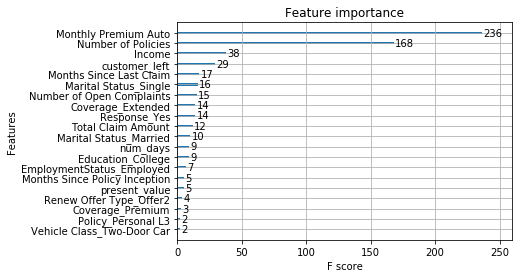

In [26]:
data_c = data.copy()
data_c = data_c.sort_values('Customer Lifetime Value')
data_c['labels'] = -1
for idx, i in enumerate(data_c.index.tolist()):
    if( int(idx/(int(data_c.shape[0]/3))) < 2):
        data_c.loc[i,'labels'] = 0
    else:
        data_c.loc[i,'labels'] = 1
data_c.drop(['Customer Lifetime Value'], axis=1, inplace=True)
X_clas = data_c.drop(['labels'], axis=1)
Y_clas = data_c.labels
# split data into train and test sets
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_clas, Y_clas, test_size=test_size, random_state=seed)
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

from sklearn.metrics import accuracy_score# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from xgboost import plot_importance
plot_importance(model, max_num_features=20)

In [27]:
( (data_c.groupby('labels')['Months Since Last Claim'].mean()[1])*(data['Months Since Last Claim'].max() - data['Months Since Last Claim'].min())) + (data['Months Since Last Claim'].min()) 

0.4269674514585871